In [1]:
import numpy as np
import scipy
import re
import collections
from collections import defaultdict
import datetime
import random

import matplotlib.pyplot as plt
%matplotlib inline


import spacy
from spacy.symbols import ORTH
#!python -m spacy download en
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, ToktokTokenizer, RegexpTokenizer

import gensim
from gensim import models
from gensim import corpora

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Предобработка текстов и подготовка признаков

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))

print()
print(train_source['data'][0].strip())


print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [3]:
def preprocess(corpus, whitespaces=True, punctuation=True, numbers=True):
    corpus = re.sub(r"[^a-zA-Z0-9.?! ]+", " ", corpus.lower().strip()) 
    if whitespaces == True:
        corpus = re.sub(r"[' ']{2,}", " ", corpus)
    if punctuation == True:
        corpus = re.sub(r"[,.!?:;%]+", " ", corpus)
    if numbers == True:
        corpus = re.sub(r"[0-9]+", "", corpus)        
    return corpus

In [596]:
preprocess(train_source['data'][0])

'from lerxst wam umd edu where s my thing subject what car is this  nntp posting host rac wam umd edu organization university of maryland college park lines  i was wondering if anyone out there could enlighten me on this car i saw the other day  it was a  door sports car looked to be from the late s early s  it was called a bricklin  the doors were really small  in addition the front bumper was separate from the rest of the body  this is all i know  if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail  thanks il brought to you by your neighborhood lerxst '

In [4]:
# initializing spacy tokenizer adding stopwords from nltk
nlp = English()
nlp.Defaults.stop_words |= set(stopwords.words('english')) - set(nlp.Defaults.stop_words)
tokenizer = Tokenizer(nlp.vocab)

In [5]:
# preprocessing and following tokenization 
train_tokens = [list(map(str, tokenizer(preprocess(sentence)))) for sentence in train_source['data']]
test_tokens = [list(map(str, tokenizer(preprocess(sentence)))) for sentence in test_source['data']]

In [6]:
# initializing sklearn TfidfVectorizer
max_df = 0.80
min_df = 0.01
vectorizer = TfidfVectorizer(preprocessor=preprocess, max_df=max_df, 
                             min_df=min_df)

In [7]:
# tfidf transform
train_vectors = vectorizer.fit_transform(train_source['data'])
test_vectors = vectorizer.fit_transform(test_source['data'])

In [602]:
train_tokens

[['from',
  'lerxst',
  'wam',
  'umd',
  'edu',
  'where',
  's',
  'my',
  'thing',
  'subject',
  'what',
  'car',
  'is',
  'this',
  ' ',
  'nntp',
  'posting',
  'host',
  'rac',
  'wam',
  'umd',
  'edu',
  'organization',
  'university',
  'of',
  'maryland',
  'college',
  'park',
  'lines',
  ' ',
  'i',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'i',
  'saw',
  'the',
  'other',
  'day',
  ' ',
  'it',
  'was',
  'a',
  ' ',
  'door',
  'sports',
  'car',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  's',
  'early',
  's',
  ' ',
  'it',
  'was',
  'called',
  'a',
  'bricklin',
  ' ',
  'the',
  'doors',
  'were',
  'really',
  'small',
  ' ',
  'in',
  'addition',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  ' ',
  'this',
  'is',
  'all',
  'i',
  'know',
  ' ',
  'if',
  'anyone',
  'can',
  'tellme',
  'a',


In [607]:
print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 2066)
Размерность матрицы признаков тестовой выборки (7532, 2017)

Количество ненулевых элементов в обучающей выборке 1043425
Процент заполненности матрицы признаков 4.46%

Количество ненулевых элементов в тестовой выборке 684644
Процент заполненности матрицы признаков 4.51%


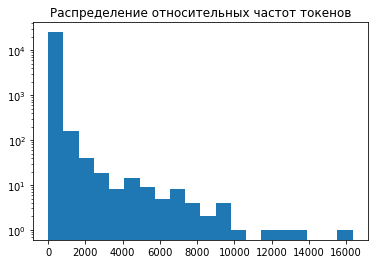

In [609]:
plt.hist(freqs, bins=20)
plt.title('Распределение относительных частот токенов')
plt.yscale('log');

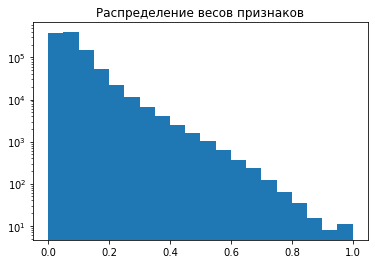

In [608]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

## LDA model

In [8]:
# creating dictionary by gensim
train_dic = corpora.Dictionary(train_tokens)
train_dic.filter_extremes(no_below=5, no_above=0.5)
freqs = [pair[1] for pair in train_dic.most_common(len(train_dic))]
bow = [train_dic.doc2bow(sentence) for sentence in train_tokens]

In [9]:
# tfidf calculation
tfidf = models.TfidfModel(bow)
corpus_tfidf = tfidf[bow]

In [10]:
# lda topic modeling
lda = models.LdaModel(corpus=bow, num_topics=20, id2word=train_dic)
doc_lda = lda[bow]
#lda.show_topics(20)

## Обучение модели на PyTorch

In [36]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Ошибка при обучении: name 'copy_data_to_device' is not defined
Traceback (most recent call last):
  File "<ipython-input-12-df4bbf2ddfff>", line 68, in train_eval_loop
    batch_x = copy_data_to_device(batch_x, device)
NameError: name 'copy_data_to_device' is not defined



In [ ]:

train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

## Альтернативная реализация на scikit-learn

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer()),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

In [25]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

RuntimeError: expected scalar type Long but found Int